In [1]:
import os
import sys
maindir = os.getcwd()
sys.path.append(maindir+"/src")

### This notebooks aims at estimating an enveloppe of distributions containing all climate models distributions

In [2]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt

from preprocessing import data_processing, compute_anomalies, \
                            compute_forced_response, compute_variance, \
                            merge_runs, stack_runs, numpy_to_torch, standardize, \
                            build_training_and_test_sets, build_training_and_test_sets_stacked

from plot_tools import plot_gt_vs_pred, animation_gt_vs_pred
from leave_one_out import leave_one_out_single, leave_one_out_procedure
from cross_validation import cross_validation_procedure

In [3]:
############### Load climate model raw data for SST
with open('data/ssp585_time_series.pkl', 'rb') as f:
    data = pickle.load(f)

###################### Load longitude and latitude 
with open('data/lon.npy', 'rb') as f:
    lon = np.load(f)

with open('data/lat.npy', 'rb') as f:
    lat = np.load(f)

# define grid (+ croping for latitude > 60)
lat_grid, lon_grid = np.meshgrid(lat[lat<=60], lon, indexing='ij')

lat_size = lat_grid.shape[0]
lon_size = lon_grid.shape[1]

In [4]:
# define pytorch precision
dtype = torch.float32

data_processed, notnan_idx, nan_idx = data_processing(data, lon, lat,max_models=100)
x = compute_anomalies(data_processed, lon_size, lat_size, nan_idx, time_period=33)
y = compute_forced_response(data_processed, lon_size, lat_size, nan_idx, time_period=33)
vars = compute_variance(x, lon_size, lat_size, nan_idx, time_period=33)

# convert numpy arrays to pytorch 
x, y, vars = numpy_to_torch(x,y,vars)

# standardize data 
x, y = standardize(x,y,vars)

# stack runs for each model
x, y, vars = stack_runs(x,y,vars,time_period=33,lon_size=lon_size,lat_size=lat_size,dtype=dtype)

# stack runs for each model
x_merged, y_merged, vars_merged = merge_runs(x,y,vars)

/home/vcohen/cope/src/preprocessing.py:109: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(y_tmp,axis=1)
/home/vcohen/cope/src/preprocessing.py:110: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(mean_ref_ensemble,axis=0)
/home/vcohen/cope/src/preprocessing.py:152: RuntimeWarning: Mean of empty slice
  mean_spatial_ensemble = np.nanmean(y_tmp,axis=0)
/home/vcohen/cope/src/preprocessing.py:156: RuntimeWarning: Mean of empty slice
  data_forced_response[m][r] = mean_spatial_ensemble - np.nanmean(mean_spatial_ensemble,axis=0)


### Compute empirical distribution

In [6]:
m0 = 'CAS-ESM2-0'

training_models, x_train, y_train, x_test, y_test = build_training_and_test_sets_stacked(m0,x,y,vars,lon_size,lat_size,time_period=33,dtype=dtype)

In [7]:
x_train.shape

torch.Size([713, 33, 2160])

In [8]:
# compute expectation of the training set
mu = torch.mean(x_train, axis=0)
sigma2 = torch.mean((x_train - mu)**2, axis=0)

/tmp/ipykernel_17269/1256847126.py:5: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(torch.range(0,32), x_train[10,:,1100],linewidth=1)
/tmp/ipykernel_17269/1256847126.py:6: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(torch.range(0,32), x_train[11,:,1100],linewidth=1)
/tmp/ipykernel_17269/1256847126.py:7: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(torch.range(0,32), x_train[20,:,1100],linewidth=1)
/tmp/ipykernel_17269/1256847126.py:8: UserWarning: torch.range is d

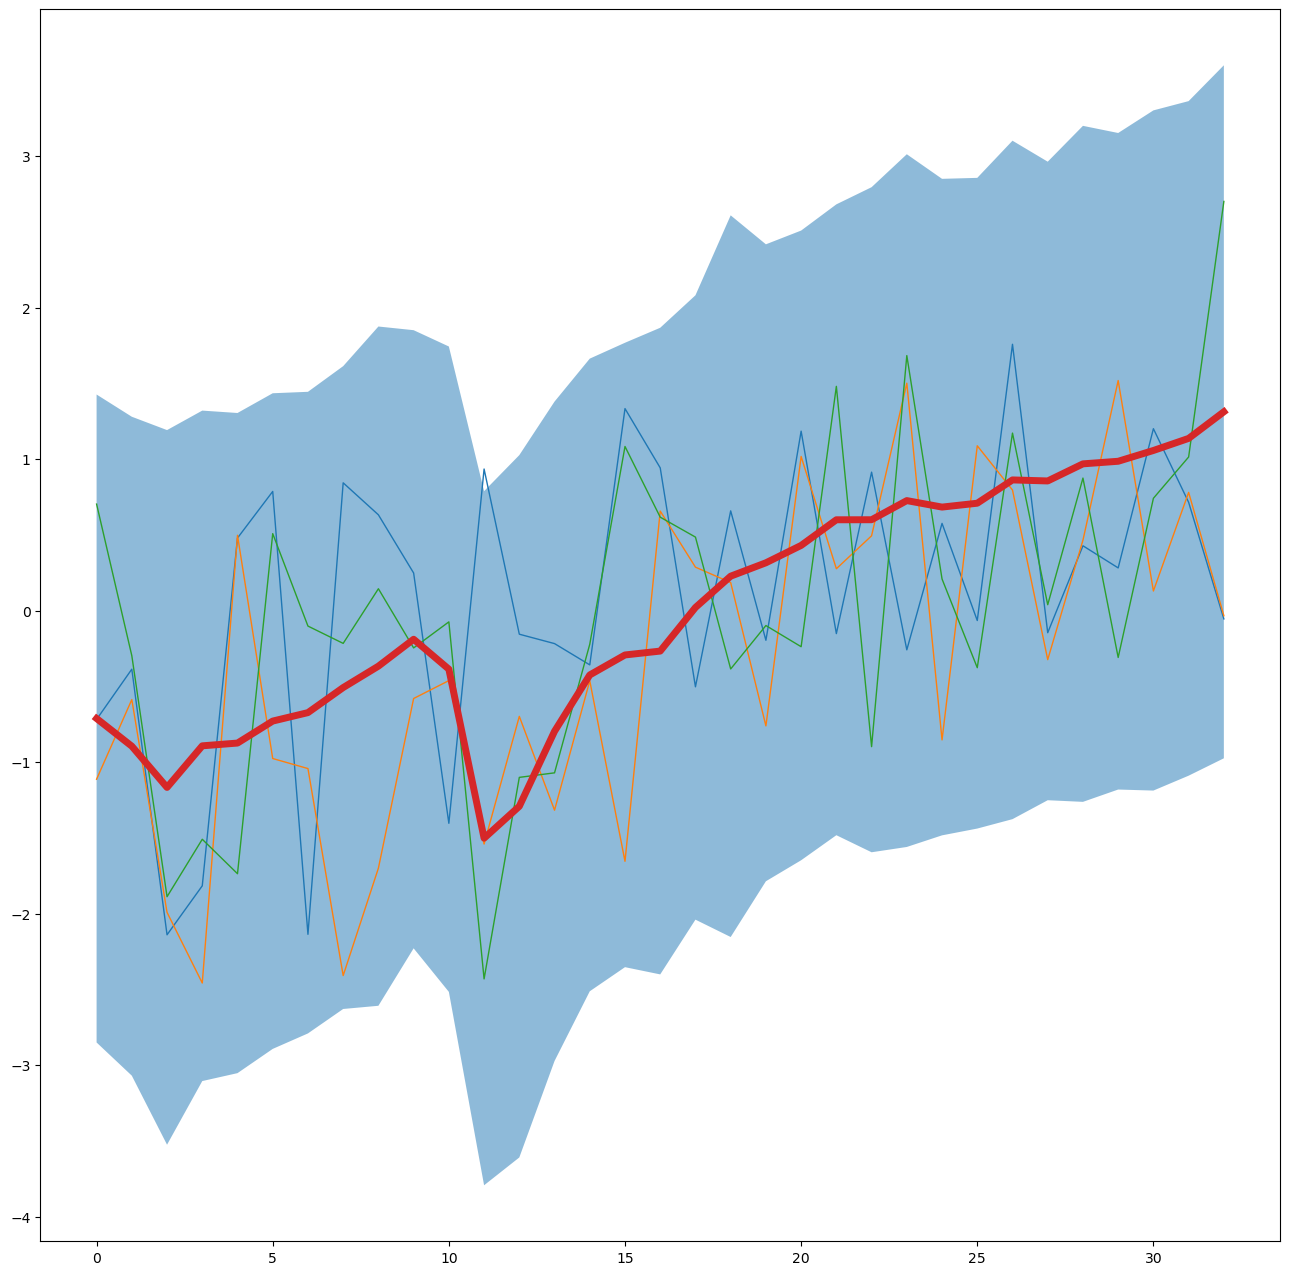

In [9]:
idx_grid_cell = 1100

plt.close("all")
plt.figure(figsize=(16,16))    
plt.plot(torch.range(0,32), x_train[10,:,1100],linewidth=1)
plt.plot(torch.range(0,32), x_train[11,:,1100],linewidth=1)
plt.plot(torch.range(0,32), x_train[20,:,1100],linewidth=1)
plt.plot(torch.range(0,32), mu[:,1100],linewidth=5)
plt.fill_between(torch.range(0,32), mu[:,1100] - 2*torch.sqrt(sigma2)[:,1100], mu[:,1100] + 2*torch.sqrt(sigma2)[:,1100], alpha=0.5)
plt.show()

##